# Notebook 03b | Modelagem SARIMA

Objetivos:

- Tratar outliers nos resíduos da série mensal antes de modelar  
- Aplicar SARIMA em duas janelas de treino-teste  
  1. Treino: 2016–2018, Teste: 2019  
  2. Treino: 2016–2019, Teste: 2020–2021  
- Avaliar desempenho das previsões (MAE, RMSE, R²)  



In [0]:
#%pip install statsmodels scikit-learn

## 1. Configuração do Ambiente

Inicializar Spark, importar bibliotecas, definir caminho dos dados Gold mensais e definir funções de métricas.

In [0]:
# Inicializar Spark e importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

spark = SparkSession.builder.getOrCreate()

# Caminho da camada Gold mensal no DBFS
gold_monthly_path = "/FileStore/gold/sales_monthly_gold"

# Funções de métricas de avaliação
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else np.nan



## 2. Leitura e Preparação da Série Mensal

Carregar Parquet via Spark, converter para pandas e criar série com frequência mensal.


In [0]:
# Carregar dados Gold mensal com Spark
df_spark = (
    spark.read
         .format("parquet")
         .load(gold_monthly_path)
         .withColumn("month_start", to_date("month_start"))
)

# Converter para pandas e garantir tipo datetime
df = df_spark.toPandas()
df['month_start'] = pd.to_datetime(df['month_start'])

# Criar série temporal com frequência mensal
series = df.set_index('month_start')['total_sales_usd'].asfreq('MS')


## 3. Decomposição e Tratamento de Outliers nos Resíduos

Decompor a série e winsorizar resíduos entre os percentis 1% e 99%.


In [0]:
# Decomposição aditiva da série temporal
decomp = seasonal_decompose(series, model='additive', period=12)
resid = decomp.resid

# Winsorizar resíduos para reduzir impacto de outliers
lower, upper = resid.quantile(0.01), resid.quantile(0.99)
resid_clipped = resid.clip(lower, upper)

# Reconstruir série ajustada sem valores nulos
t_series = decomp.trend + decomp.seasonal + resid_clipped
series_adj = t_series.dropna()


## 4. Janela 1: Treino 2016–2018, Teste 2019

Ajustar SARIMA e avaliar previsões para 2019.


In [0]:
# Definir treino e teste
train1 = series_adj[:'2018-12-01']
test1  = series_adj['2019-01-01':'2019-12-01']

# Ajuste do modelo SARIMA(1,1,1)(1,1,1,12)
model1 = SARIMAX(train1, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)

# Previsão para o período de teste
forecast1 = model1.forecast(steps=len(test1))

# Exibir desempenho
print("Desempenho SARIMA Janela 1 (2019):")
print(f"MAE:  {mae(test1, forecast1):.2f}")
print(f"RMSE: {rmse(test1, forecast1):.2f}")
print(f"R2:   {r2(test1, forecast1):.4f}")


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Desempenho SARIMA Janela 1 (2019):
MAE:  350026.97
RMSE: 384945.53
R2:   0.5313


## 5. Janela 2: Treino 2016–2019, Teste 2020–2021

Ajustar SARIMA e avaliar previsões para o período da pandemia.


In [0]:
# Definir treino e teste
train2 = series_adj[:'2019-12-01']
test2  = series_adj['2020-01-01':]

# Ajuste do modelo SARIMA(1,1,1)(1,1,1,12)
model2 = SARIMAX(train2, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)

# Previsão para o período de teste
forecast2 = model2.forecast(steps=len(test2))

# Exibir desempenho
print("\nDesempenho SARIMA Janela 2 - Pandemia (2020–2021):")
print(f"MAE:  {mae(test2, forecast2):.2f}")
print(f"RMSE: {rmse(test2, forecast2):.2f}")
print(f"R2:   {r2(test2, forecast2):.4f}")

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



Desempenho SARIMA Janela 2 - Pandemia (2020–2021):
MAE:  716968.98
RMSE: 870149.32
R2:   -0.5361


## 6. Gráficos das Previsões vs Real

Visualizar previsões e valores reais para ambas as janelas.


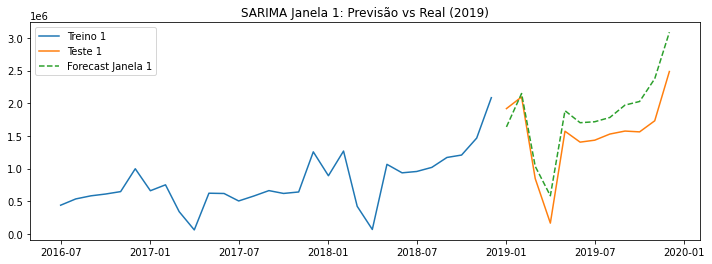

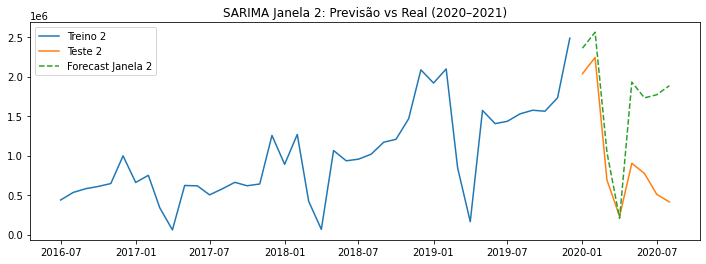

In [0]:
import matplotlib.pyplot as plt

# Plot Janela 1
plt.figure(figsize=(12,4))
plt.plot(train1.index, train1, label='Treino 1')
plt.plot(test1.index, test1, label='Teste 1')
plt.plot(forecast1.index, forecast1, '--', label='Forecast Janela 1')
plt.title('SARIMA Janela 1: Previsão vs Real (2019)')
plt.legend()
plt.show()

# Plot Janela 2
plt.figure(figsize=(12,4))
plt.plot(train2.index, train2, label='Treino 2')
plt.plot(test2.index, test2, label='Teste 2')
plt.plot(forecast2.index, forecast2, '--', label='Forecast Janela 2')
plt.title('SARIMA Janela 2: Previsão vs Real (2020–2021)')
plt.legend()
plt.show()


## 6. Conclusões

- **Janela 1 (2019):**  
  - MAE ≈ 350 k, RMSE ≈ 385 k e R² = 0.531 indicam ajuste moderado.  
  - O modelo captura razoavelmente a tendência e a sazonalidade pré-pandemia. 

- **Janela 2 (2020–2021):**  
  - MAE ≈ 717 k, RMSE ≈ 870 k e R² = –0.536 mostram desempenho ruim.  
  - Como era esperado, a ruptura provocada pela pandemia não foi explicada pelo padrão SARIMA, gerando previsões piores que a média.  


## 7. Próximos Passos

- Comparar o desempenho do modelo SARIMA com o Prophet